### Current API supports all types of permeability map in isotropic 2d cases, the input/output are consistent with what you see on CCSNet.ai. You can update 'type_of_permeability_map' of input_arguments dict to try different types of permeability map
- type_of_permeability_map = Synthetic Heterogeneous, API only uses parameters in the input_arguments as input
- type_of_permeability_map = Homogeneous, side bar input and 'permeability' are used, main page input are not used
- type_of_permeability_map = User Upload, side bar input is used, you also need to upload a file

In [1]:
import requests
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json
import pandas as pd
import random

pd.reset_option('all')

In [2]:
url = 'http://20.119.44.37/isotropic_2d'

# Synthetic Heterogeneous

## Starter code

In [6]:
thickness = int(200 / 2.08333)

dx = np.cumsum(3.5938 * np.power(1.035012, range(200))) + 0.1
dx = np.insert(dx, 0, 0.1)
y = np.linspace(0, thickness * 2.0833, num=thickness)

## Random sampling

In [7]:
# All depths are measured from the surface of the earth

water_tab = 10 # water table in m

t_surf = 15 # average surface temperature

g = 9.8 # acceleration due to gravity in m/s2

# Original run

rho_water = 1000 # density of water in kg/m3

rho_brines = [1020] # np.linspace(1020, 1100, 5) # brine densities in kg/m3 

inj_rates = [1] # [2] # np.linspace(0.25, 2, 8) # injection rates in MT/year 

geo_grads= [25] # geothermal gradient in oC/km 

depths_bottom_usdw = [100] # np.linspace(100, 350, 6) # depth to bottom of USDW in m 

depths_top_res = [1500] # [1000] # np.linspace(800, 1800, 11) # depth to top of reservoir in m

thicks_res = [100] # np.linspace(50, 200, 7) # thickness of reservoir in m

perms_res = [500] # np.array([10, 50, 100, 250, 500, 1000]) # np.linspace(800, 850, 2) # permeability of reservoir in mD

# std_dev_to_perm_res_ratios = np.linspace(0, 2, 11) # [random.uniform(0, 0.5)]

In [8]:
data_result = []

iter = 0

# total_iter = len(rho_brines) * len(inj_rates) * len(geo_grads) * len(depths_bottom_usdw) * len(depths_top_res) * len(thicks_res) * len(perms_res) * 1 # len(std_dev_to_perm_res_ratios)

total_iter = 5 # 6 * 50

while iter < total_iter:

    for rho_brine in rho_brines:
      for inj_rate in inj_rates:
        for geo_grad in geo_grads:
          for depth_bottom_usdw in depths_bottom_usdw:
            for depth_top_res in depths_top_res:
              for thick_res in thicks_res:
                for perm_res in perms_res:
                  for std_dev_to_perm_res_ratio in [1]: #std_dev_to_perm_res_ratios:  
                    
                      # total_iters = len(rho_brines) * len(inj_rates) * len(geo_grads) * len(depths_bottom_usdw) * len(depths_top_res) * len(thicks_res) * len(perms_res)
        
                      if iter == 0:
                          print('Total iterations', total_iter)
        
                      # if thick_res / inj_rate < 100: 
                      #     continue # skipping cases where injection rate is too high for a given thickness
        
                      # if (depth_bottom_usdw in depths_bottom_usdw_old) and (depth_top_res in depths_top_res_old) and (thick_res in thicks_res_old) and (perm_res in perms_res_old):
                      #     continue # skipping cases already done
        
                      input_arguments = {
                          # side bar input
                          'initial_pressure': rho_water * g * (depth_top_res - water_tab) * 1e-5, # pressure at top of reservoir in bar
                          'reservoir_temperature': t_surf + geo_grad * (depth_top_res + thick_res / 2) / 1000, # temperature in middle of reservoir
                          'thickness_m': thick_res,
                          'injection_rate': inj_rate,
                          'well_top': thick_res,
                          'perf_thick': thick_res,
                          'irr_water_saturation': 0.2,
                          'capillary_lambda': 0.5,
        
                          # main page inputs not used for homogeneous case
                          'type_of_permeability_map': "Synthetic Heterogeneous",
                          'permeability_map_medium': "Gaussian",
                          'continuity_of_layers': "Continuous",
                          'mean_permeability': int(perm_res),
                          'standard_deviation': int(perm_res * random.uniform(0, 0.5)),
                          'vertical_correlation': random.randint(2, 10),
                          'lateral_correlation': random.randint(2, 10) * random.randint(5, 50),
                          'random_seed': random.randint(1, 12345),
        
                          # only need to be set when type_of_permeability_map=Homogeneous
                          'permeability': int(perm_res)
        
                      }
        
                      files = {}
        
                      args_json = json.dumps(input_arguments)
        
                      data = {
                          'args_json': (None, args_json),  # Tuple with None as filename indicates it's not a file
                      }
        
                      response = requests.post(url, files=files, data=data)
        
                      # print(response.status_code) # 200 to ensure success
        
                      if response.status_code != 200:
                          continue # skip the current iteration because failure
                        
                      response_json = response.json()
        
                      gas_saturation = np.array(response_json['gas_saturation'])
                      pressure_buildup = np.array(response_json['pressure_buildup'])
                      # reservoir_pressure = np.array(response_json['reservoir_pressure'])
                      # molar_fraction_of_dissolved_phase = np.array(response_json['molar_fraction_of_dissolved_phase'])
        
                      # draw_real_figure(gas_saturation[:,:,23], "Gas saturation", '', thickness)
                      # draw_real_figure(pressure_buildup[:,:,23], "Pressure buildup", '', thickness)
                      # draw_real_figure(reservoir_pressure[:,:,23], "CO2 gas saturation", '', thickness)
                      # draw_real_figure(molar_fraction_of_dissolved_phase[:,:,23], "CO2 gas saturation", '', thickness)
        
                      # Extracting plume radius
        
                      plume_index = np.max(np.argmin(gas_saturation[:, :, 23], axis=1))
        
                      plume_rad = dx[plume_index]
        
                      # print('Plume radius in m', plume_radius)
        
                      # Exctracting pressure front
        
                      p_crit = (rho_brine - rho_water) * g * (depth_top_res - depth_bottom_usdw) * 1e-5 # critical pressure required for buildup (in bar)
        
                      idx_pressure_front = np.argmin(pressure_buildup[0, :, 23] >= p_crit) # index of pressure front
        
                      pressure_front_rad = dx[idx_pressure_front] # radius of pressure front
        
                      # print('Pressure front in m', pressure_front_radius)
        
                      dict_result = {
                          'rho_brine': rho_brine,
                          'inj_rate': inj_rate,
                          'geo_grad': geo_grad,
                          'depth_bottom_usdw': depth_bottom_usdw,
                          'depth_top_res': depth_top_res,
                          'thick_res': thick_res,
                          'perm_res': perm_res,
                          'p_crit': p_crit,
                          'plume_rad': plume_rad,
                          'pressure_front_rad': pressure_front_rad,
                          'std_dev_to_perm_res_ratio': std_dev_to_perm_res_ratio, # input_arguments['standard_deviation'] / perm_res,
                          'vertical_correlation': input_arguments['vertical_correlation'],
                          'lateral_correlation': input_arguments['lateral_correlation'],
                          'random_seed': input_arguments['random_seed']
                      }
        
                      data_result.append(dict_result)
        
                      iter += 1
                        
                      if iter % 10 == 0: 
                          print('Completed iter', iter, 'of', total_iter)

df_result_hetero = pd.DataFrame(data_result)

# df_result_hetero.to_csv('Output_heterogeneous' + str(iter) + '_Nov24_' + '.csv') # uncomment to save file locally

df_result_hetero

Total iterations 5


,rho_brine,inj_rate,geo_grad,depth_bottom_usdw,depth_top_res,thick_res,perm_res,p_crit,plume_rad,pressure_front_rad,std_dev_to_perm_res_ratio,vertical_correlation,lateral_correlation,random_seed
0,1020,1,25,100,1500,100,500,2.744,3575.838906,764.318975,1,8,84,11507
1,1020,1,25,100,1500,100,500,2.744,3704.626476,652.841865,1,8,315,11199
2,1020,1,25,100,1500,100,500,2.744,3837.923157,1350.007011,1,9,21,11867
3,1020,1,25,100,1500,100,500,2.744,3102.805433,1120.393950,1,7,270,5068
4,1020,1,25,100,1500,100,500,2.744,3704.626476,679.289463,1,6,35,4878


In [9]:
df_result_hetero.pressure_front_rad.std() / df_result_hetero.pressure_front_rad.mean()

# df_result_hetero.pressure_front_rad.mean()

# df_result_hetero.pressure_front_rad.std()

0.33674114629269986

In [10]:
df_result_hetero.plume_rad.std() / df_result_hetero.plume_rad.mean()

# df_result_hetero.plume_rad.mean()

# df_result_hetero.plume_rad.std()

0.07952931136536955

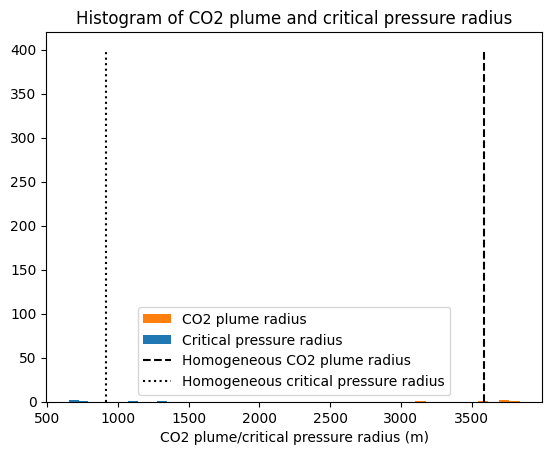

In [11]:
plt.hist(df_result_hetero.plume_rad, color='#ff7f0e', label='CO2 plume radius')
plt.hist(df_result_hetero.pressure_front_rad, color='#1f77b4', label='Critical pressure radius')
plt.plot(np.array([df_result_hetero.plume_rad.mean(), df_result_hetero.plume_rad.mean()]), np.array([0, 400]), '--', color='k',  label='Homogeneous CO2 plume radius')
plt.plot(np.array([df_result_hetero.pressure_front_rad.mean(), df_result_hetero.pressure_front_rad.mean()]), np.array([0, 400]), ':', color='k', label='Homogeneous critical pressure radius')
plt.title('Histogram of CO2 plume and critical pressure radius')
plt.xlabel('CO2 plume/critical pressure radius (m)')
plt.legend()

# Homogeneous

## Initializing variables and creating dataframe

In [12]:
# All depths are measured from the surface of the earth

water_tab = 10 # water table in m

t_surf = 15 # average surface temperature

g = 9.8 # acceleration due to gravity in m/s2

# Original run

rho_water = 1000 # density of water in kg/m3

rho_brines_old = np.linspace(1020, 1100, 5) # brine densities in kg/m3 

inj_rates_old = np.linspace(0.25, 2, 8) # injection rates in MT/year 

depths_bottom_usdw_old = np.linspace(100, 350, 6) # np.linspace(100, 250, 4) # depth to bottom of USDW in m 

depths_top_res_old = np.linspace(800, 1800, 11) # np.linspace(200, 1800, 5) # depth to top of reservoir in m

thicks_res_old = np.linspace(50, 200, 7) # np.linspace(50, 200, 4) # thickness of reservoir in m

perms_res_old = np.linspace(50, 1000, 20) # permeability of reservoir in mD

# New run

rho_brines = np.linspace(1010, 1030, 3) # np.linspace(1040, 1200, 5) # brine densities in kg/m3 

inj_rates = np.linspace(0.25, 2, 8) # injection rates in MT/year 

geo_grads = [25] # geothermal gradient in oC/km 

depths_bottom_usdw = np.linspace(100, 350, 6) # depth to bottom of USDW in m 

depths_top_res =  np.linspace(800, 1000, 3) # depth to top of reservoir in m 

thicks_res = np.linspace(50, 200, 7) # thickness of reservoir in m

perms_res = np.linspace(5, 45, 9) # np.linspace(50, 1000, 20) # permeability of reservoir in mD

In [13]:
# Checking number of iterations

total_iter = 0

for rho_brine in rho_brines:
  for inj_rate in inj_rates:
    for geo_grad in geo_grads:
      for depth_bottom_usdw in depths_bottom_usdw:
        for depth_top_res in depths_top_res:
          for thick_res in thicks_res:
            for perm_res in perms_res:
                
              if thick_res / inj_rate < 100: 
                  continue # skipping cases where injection rate is too high for a given thickness

              if (rho_brine in rho_brines_old) and (inj_rate in inj_rates_old) and (depth_bottom_usdw in depths_bottom_usdw_old) and (depth_top_res in depths_top_res_old) and (thick_res in thicks_res_old) and (perm_res in perms_res_old):
                  continue # skipping cases already done

              total_iter += 1

print('Actual new iterations', total_iter)
print('Estimated number of hours', total_iter / 1000)
print('Estimated number of days', total_iter / 24000)
print('Naive estimate', len(rho_brines) * len(inj_rates) * len(geo_grads) * len(depths_bottom_usdw) * len(depths_top_res) * len(thicks_res) * len(perms_res))

Actual new iterations 17010
Estimated number of hours 17.01
Estimated number of days 0.70875
Naive estimate 27216


## Looping through all iterations

In [14]:
data_result = []

iter = 0
skips = 0
fails = 0

print('Total iterations', total_iter)

for rho_brine in rho_brines:
  for inj_rate in inj_rates:
    for geo_grad in geo_grads:
      for depth_bottom_usdw in depths_bottom_usdw:
        for depth_top_res in depths_top_res:
          for thick_res in thicks_res:
            for perm_res in perms_res:

              # total_iters = len(rho_brines) * len(inj_rates) * len(geo_grads) * len(depths_bottom_usdw) * len(depths_top_res) * len(thicks_res) * len(perms_res)

              # if iter == 0:
              #     print('Total iterations', total_iter)

              if thick_res / inj_rate < 100: 
                  print('1Skip' + str(skips))
                  skips += 1
                  continue # skipping cases where injection rate is too high for a given thickness

              if (rho_brine in rho_brines_old) and (inj_rate in inj_rates_old) and (depth_bottom_usdw in depths_bottom_usdw_old) and (depth_top_res in depths_top_res_old) and (thick_res in thicks_res_old) and (perm_res in perms_res_old):
                  print('2Skip' + str(skips))
                  skips += 1
                  continue # skipping cases already done
                
              input_arguments = {
                  # side bar input
                  'initial_pressure': rho_water * g * (depth_top_res - water_tab) * 1e-5, # pressure at top of reservoir in bar
                  'reservoir_temperature': t_surf + geo_grad * (depth_top_res + thick_res / 2) / 1000, # temperature in middle of reservoir
                  'thickness_m': thick_res,
                  'injection_rate': inj_rate,
                  'well_top': thick_res,
                  'perf_thick': thick_res,
                  'irr_water_saturation': 0.2,
                  'capillary_lambda': 0.5,

                  # main page inputs not used for homogeneous case
                  'type_of_permeability_map': "Homogeneous",
                  'permeability_map_medium': "Gaussian",
                  'continuity_of_layers': "Continuous",
                  'mean_permeability': 50,
                  'standard_deviation': 15,
                  'vertical_correlation': 20,
                  'lateral_correlation': 1000,
                  'random_seed': 12345,

                  # only need to be set when type_of_permeability_map=Homogeneous
                  'permeability': int(perm_res)

              }

              files = {}

              args_json = json.dumps(input_arguments)

              data = {
                  'args_json': (None, args_json),  # Tuple with None as filename indicates it's not a file
              }

              response = requests.post(url, files=files, data=data)

              # print(response.status_code) # 200 to ensure success

              if response.status_code != 200:
                  fails += 1
                  print('Failure' + str(fails))
                  continue # skip the current iteration because failure
                
              response_json = response.json()

              gas_saturation = np.array(response_json['gas_saturation'])
              pressure_buildup = np.array(response_json['pressure_buildup'])
              # reservoir_pressure = np.array(response_json['reservoir_pressure'])
              # molar_fraction_of_dissolved_phase = np.array(response_json['molar_fraction_of_dissolved_phase'])

              # draw_real_figure(gas_saturation[:,:,23], "Gas saturation", '', thickness)
              # draw_real_figure(pressure_buildup[:,:,23], "Pressure buildup", '', thickness)
              # draw_real_figure(reservoir_pressure[:,:,23], "CO2 gas saturation", '', thickness)
              # draw_real_figure(molar_fraction_of_dissolved_phase[:,:,23], "CO2 gas saturation", '', thickness)

              # Extracting plume radius

              plume_index = np.max(np.argmin(gas_saturation[:, :, 23], axis=1))

              plume_rad = dx[plume_index]

              # print('Plume radius in m', plume_radius)

              # Exctracting pressure front

              p_crit = (rho_brine - rho_water) * g * (depth_top_res - depth_bottom_usdw) * 1e-5 # critical pressure required for buildup (in bar)

              idx_pressure_front = np.argmin(pressure_buildup[0, :, 23] >= p_crit) # index of pressure front

              pressure_front_rad = dx[idx_pressure_front] # radius of pressure front

              # print('Pressure front in m', pressure_front_radius)

              dict_result = {
                  'rho_brine': rho_brine,
                  'inj_rate': inj_rate,
                  'geo_grad': geo_grad,
                  'depth_bottom_usdw': depth_bottom_usdw,
                  'depth_top_res': depth_top_res,
                  'thick_res': thick_res,
                  'perm_res': perm_res,
                  'p_crit': p_crit,
                  'plume_rad': plume_rad,
                  'pressure_front_rad': pressure_front_rad
              }

              data_result.append(dict_result)

              iter += 1
                
              if iter % 5 == 0: 
                  print('Completed iter', iter, 'of', total_iter)

df_result_homo = pd.DataFrame(data_result)

# df_result_homo.to_csv('Output' + str(iter) + '_Jul16_' + '.csv') # uncomment this line to save as csv

# df_result_homo

Total iterations 17010
Completed iter 5 of 17010


KeyboardInterrupt: 